In [7]:
import numpy as np
import os
from time import time
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
sns.set(style="darkgrid")

In [21]:
start = time()

# Set the constants
# -----------------------------------------------------------------------------------
r = 0
S0 = k = 2.0
t_max = 1.0
V0 = 0.010201
sigma = 0.61
theta = 0.019
kappa = 6.21

rho_choice = np.array([-0.5, -0.7, -0.9])
rho_probability = np.array([0.25, 0.5, 0.25])

n = 400 # n time periods
m = n * n # number of simulations

Stock prices simulation:

In [24]:
def stock_price_generator (t_max, n ,m, r, S0, k, V0, sigma, theta, kappa, rho_choice, rho_probability):
    dt = t_max / n
    
    # Brownian motions:
    dw_v = np.random.normal(size=(m, n)) * np.sqrt(dt)
    dw_i = np.random.normal(size=(m, n)) * np.sqrt(dt)

    rho = np.random.choice(rho_choice, size=(m, 1), p = rho_probability)
    dw_s = rho * dw_v + np.sqrt(1.0 - rho ** 2) * dw_i

    # Perform time evolution 
    s = np.empty((m, n + 1)) # initialisation stock prices vector
    s[:, 0] = S0

    v = np.ones(m) * V0

    for t in range(n):
        dv = kappa * (theta - v) * dt + sigma * np.sqrt(v) * dw_v[:, t]
        ds = r * s[:, t] * dt + np.sqrt(v) * s[:, t] * dw_s[:, t]

        v = np.clip(v + dv, a_min=0.0, a_max=None)
        s[:, t + 1] = s[:, t] + ds
        
        
    return s    
    

In [ ]:
s = stock_price_generator (t_max, n ,m, r, S0, k, V0, sigma, theta, kappa, rho_choice, rho_probability)

In [31]:
s

array([[2.        , 2.00814339, 2.00391873, ..., 1.88139046, 1.8574881 ,
        1.85549936],
       [2.        , 1.99147575, 1.98260936, ..., 2.00670082, 2.00463461,
        2.00158622],
       [2.        , 2.00463652, 1.99577196, ..., 1.75267857, 1.75118276,
        1.75240384],
       ...,
       [2.        , 2.01357488, 1.99745324, ..., 2.08745235, 2.09008763,
        2.09238716],
       [2.        , 2.0024389 , 2.00304098, ..., 1.9472892 , 1.95066673,
        1.94825176],
       [2.        , 1.99297408, 2.00207584, ..., 2.12212081, 2.12916884,
        2.14150372]])

In [32]:
len(s)

160000

In [33]:
len(s[0])

401

In [25]:
# mean and standard deviatiom
expected_price = s[:, -1].mean()
price_std = s[:, -1].std()

price_error = price_std / np.sqrt(m) # error of monte carlo

Plots stock prices simulations:

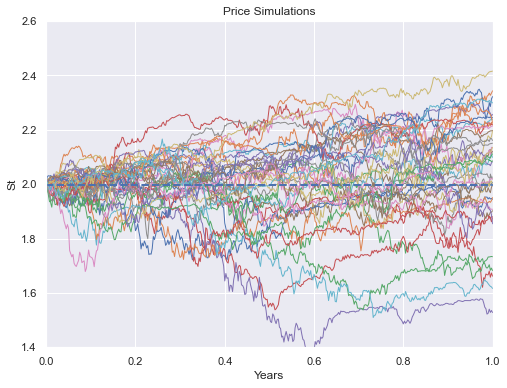

In [10]:
# Setup figure
plt.figure(figsize=(8,6))
# noinspection PyTypeChecker
ax_lines = plt.axes()

# Make the line plots
t = np.linspace(0, t_max, num=n + 1)
ns = 40
for i in range(ns):
    ax_lines.plot(t, s[i, :], lw=1.0)
ax_lines.set(xlabel='Years', ylabel='St',title='Price Simulations')
ax_lines.set_xlim((0, 1))
ax_lines.set_ylim((1.4, 2.6))

# Add mean value to line plots
ax_lines.plot([0.0, 1.0], [expected_price, expected_price], lw='2', ls="--", label='mean')
plt.show()
#plt.savefig("simulation.png")

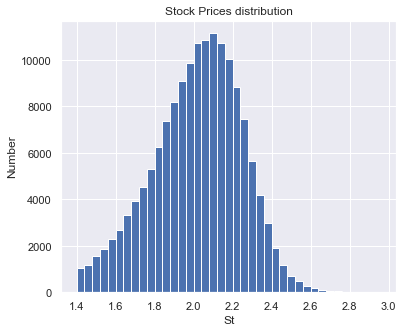

In [11]:
plt.figure(figsize=(6,5))
bins = np.arange(1.4, 3, .04)
plt.hist(s[:, -1], bins=bins)
plt.xlabel('St')
plt.ylabel('Number')
plt.title('Stock Prices distribution')
plt.show()

Payoff:

In [59]:
def find_expected_payoff(stock_path, k, r, t_max):
    payoff = max(stock_path[-1] - k, 0) # one payoff for each simulation
    c = payoff * np.exp(-r * t_max)     # in case r=0, this step is useless
    
    return c

In [75]:
payoff = []

for stock_path in s[:10]:
    payoff = np.append (payoff, find_expected_payoff(stock_path, k, r, t_max))
    

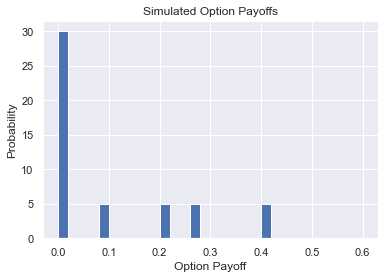

In [78]:
# Make the histogram for the Payoffs
plt.figure()
bins = np.arange(0, payoff.max() + 0.02, 0.02)
plt.hist(payoff, bins=np.arange(0.0, 0.62, 0.02), density=True)
plt.title("Simulated Option Payoffs")
plt.xlabel("Option Payoff")
plt.ylabel("Probability")
plt.savefig("payoffs.png")

In [ ]:
find_expected_payoff(stock_path, k, r, t_max)

In [12]:
# Calculate expected call option payoff and therefore option price
# -----------------------------------------------------------------------------------

payoff = np.clip(s[:, -1] - k, a_min=0, a_max=None) # one payoff for each simulation

expected_payoff = payoff.mean()
payoff_std = payoff.std()
payoff_error = payoff_std / np.sqrt(m)

In [13]:
c = expected_payoff * np.exp(-r * t_max) # in case r=0, this step is useless
c

0.09921454981446703

In [14]:
print("Expected fuel price: ${:.4f} +/- ${:.4f}.".format(expected_price, price_error))
print("Expected payoff:     ${:.4f} +/- ${:.4f}.".format(expected_payoff, payoff_error))
print(" => Option price:    ${:.4f}.".format(c))
print("Total price to cover 2 Million Gallons is ${:,.0f}.\n".format(c * 2000000))

print("Price Mean, STD:  ${:.4f}, ${:.4f}.".format(expected_price, price_std))
print("Payoff Mean, STD: ${:.4f}, ${:.4f}.\n".format(expected_payoff, payoff_std))

print("Simulation time: {:.1f} seconds.".format(time() - start))
print("Number of time steps:  {:.0f}.".format(n))
print("Number of simulations: {:,.0f}.".format(m))
print("Total number samples:  {:,.0f}.".format(m * n))

Expected fuel price: $1.9989 +/- $0.0006.
Expected payoff:     $0.0992 +/- $0.0003.
 => Option price:    $0.0992.
Total price to cover 2 Million Gallons is $198,429.

Price Mean, STD:  $1.9989, $0.2565.
Payoff Mean, STD: $0.0992, $0.1302.

Simulation time: 24.0 seconds.
Number of time steps:  400.
Number of simulations: 160,000.
Total number samples:  64,000,000.


6